In [31]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Flatten, Dropout
warnings.filterwarnings('ignore')
from keras.utils.vis_utils import plot_model

In [4]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('src/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [5]:
 # removing null values
df_har = df_har.dropna()
df_har.shape
# transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))
# drop rows where timestamp is 0
df = df_har[df_har['timestamp'] != 0]
# arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [6]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


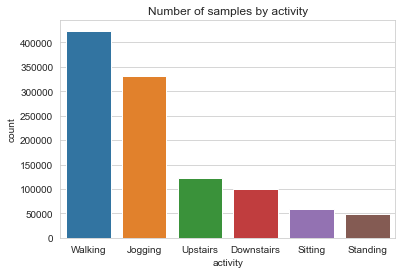

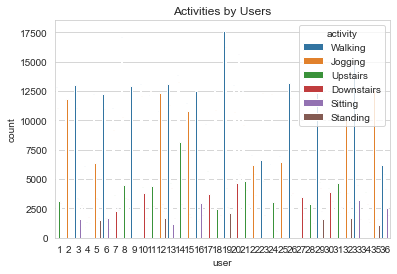

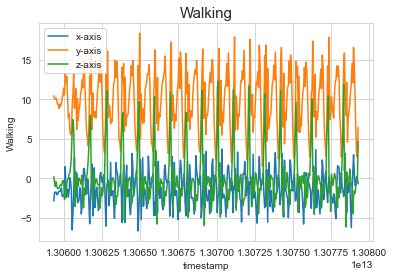

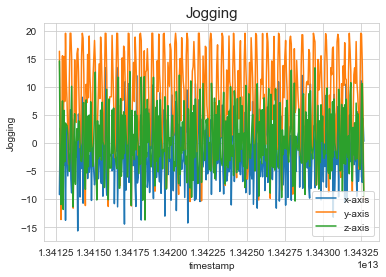

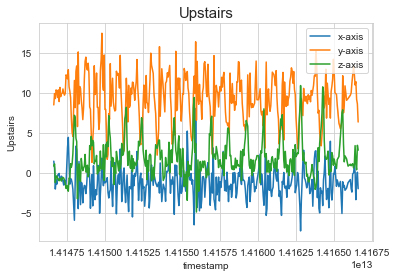

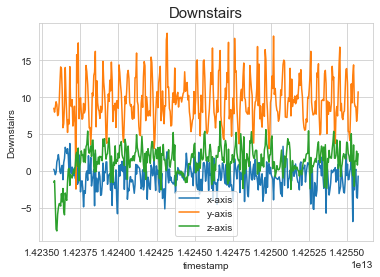

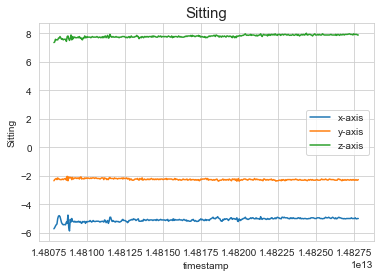

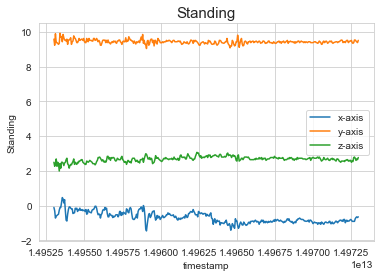

In [7]:
#streamlit
sns.set_style("whitegrid")
sns.countplot(x = "activity", data = df)
plt.title("Number of samples by activity")
plt.show()
sns.countplot(x = "user",  hue = "activity", data = df)
plt.title("Activities by Users")
plt.show()
#streamlit
activities = ["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"]
for i in activities:
    data36 = df[(df["user"] == 36) & (df["activity"] == i)][:400]
    sns.lineplot(y = "x-axis", x = "timestamp", data = data36)
    sns.lineplot(y = "y-axis", x = "timestamp", data = data36)
    sns.lineplot(y = "z-axis", x = "timestamp", data = data36)
    plt.legend(["x-axis", "y-axis", "z-axis"])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [8]:
#Each generated sequence (or window) contains 50 records corresponding to 2.5 secs of activity 
#(recall that the frequency of the data collection as mentioned in the source website is 20 Hz).
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  

    xs = df['x-axis'].values[i: i + 50]

    ys = df['y-axis'].values[i: i + 50]

    zs = df['z-axis'].values[i: i + 50]

    label = scipy.stats.mode(df['activity'][i: i + 50])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
print(pd.get_dummies(labels))
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

        Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
0                0        0        0         0         0        1
1                0        0        0         0         0        1
2                0        0        0         0         0        1
3                0        0        0         0         0        1
4                0        0        0         0         0        1
...            ...      ...      ...       ...       ...      ...
108526           0        0        0         1         0        0
108527           0        0        0         1         0        0
108528           0        0        0         1         0        0
108529           0        0        0         1         0        0
108530           0        0        0         1         0        0

[108531 rows x 6 columns]


In [14]:
y_train[0][2]

NameError: name 'y_train' is not defined

In [9]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

In [10]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50
68/68 [==============================] - 35s 479ms/step - loss: 0.9072 - accuracy: 0.6820 - val_loss: 0.5577 - val_accuracy: 0.8031
Epoch 2/50
68/68 [==============================] - 31s 456ms/step - loss: 0.5354 - accuracy: 0.8100 - val_loss: 0.4854 - val_accuracy: 0.8265
Epoch 3/50
68/68 [==============================] - 35s 512ms/step - loss: 0.4693 - accuracy: 0.8330 - val_loss: 0.4386 - val_accuracy: 0.8337
Epoch 4/50
68/68 [==============================] - 30s 441ms/step - loss: 0.4301 - accuracy: 0.8430 - val_loss: 0.3957 - val_accuracy: 0.8538
Epoch 5/50
68/68 [==============================] - 29s 423ms/step - loss: 0.3925 - accuracy: 0.8562 - val_loss: 0.3582 - val_accuracy: 0.8690
Epoch 6/50
68/68 [==============================] - 29s 422ms/step - loss: 0.3563 - accuracy: 0.8690 - val_loss: 0.3417 - val_accuracy: 0.8719
Epoch 7/50
68/68 [==============================] - 29s 425ms/step - loss: 0.3298 - accuracy: 0.8792 - val_loss: 0.3096 - val_accuracy: 0.8863

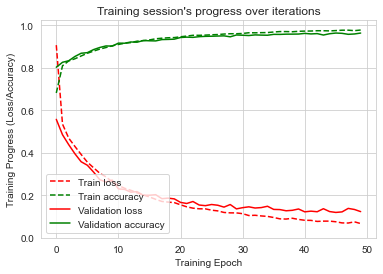

In [16]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()


In [17]:
pd.DataFrame(history.history).to_csv("src/history_test.csv")

In [21]:
model.save("./model.h5")

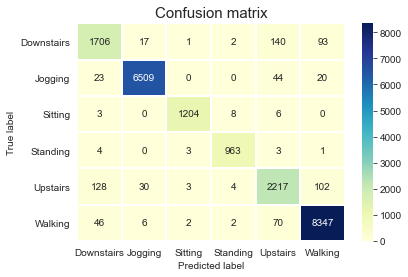

In [24]:
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
model = load_model("src/model.h5")

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________
